In [199]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import preprocessing

import math

from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

In [122]:
music_df = pd.read_csv('../music_data/billboard_top_100_1960_1969.csv', na_values=['NA'])

In [123]:
music_df.describe(include='all')

,Rank,Artist,Title,Year,SpotifyPlayCount
count,1000.000000,1000,1000,1000.000000,1.000000e+03
unique,NaN,547,987,NaN,NaN
top,NaN,The Beatles,Dedicated To The One I Love,NaN,NaN
freq,NaN,23,2,NaN,NaN
mean,50.547000,NaN,NaN,1964.501000,7.899716e+06
std,28.922799,NaN,NaN,2.875111,1.992259e+07
min,1.000000,NaN,NaN,1960.000000,1.554000e+03
25%,25.750000,NaN,NaN,1962.000000,2.437070e+05
50%,50.500000,NaN,NaN,1964.500000,8.641245e+05
75%,76.000000,NaN,NaN,1967.000000,4.963935e+06


# 1. Visualization

## 1.1 Correlation Analysis

In [129]:
# Pearson correlation analysis
correlation = music_df.corr(method='pearson')
correlation

,Rank,Year,SpotifyPlayCount
Rank,1.000000,0.002575,-0.162270
Year,0.002575,1.000000,0.166069
SpotifyPlayCount,-0.162270,0.166069,1.000000


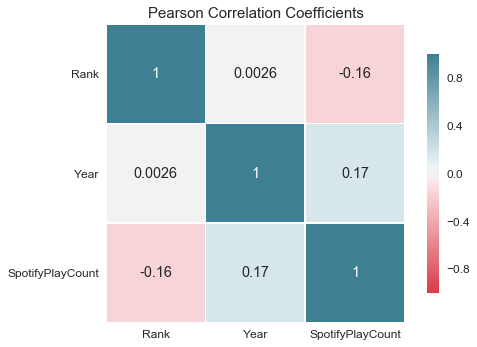

In [130]:
sns.set(style="white", font_scale=1.2)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Plot the Pearson correlation heatmap
ax = sns.heatmap(correlation, cmap=cmap, annot=True, center=0, 
                 square=True, linewidths=.7, cbar_kws={"shrink": .8})
plt.yticks(rotation=0) 
ax.set_title('Pearson Correlation Coefficients', fontsize=15)

In [144]:
# Pearson correlation analysis - log(SpotifyPlayCount)
music_df_logtarget = music_df.copy()
music_df_logtarget.SpotifyPlayCount = np.log(music_df_logtarget.SpotifyPlayCount)
correlation = music_df_logtarget.corr(method='pearson')
correlation

,Rank,Year,SpotifyPlayCount
Rank,1.000000,0.002575,-0.266992
Year,0.002575,1.000000,0.271174
SpotifyPlayCount,-0.266992,0.271174,1.000000


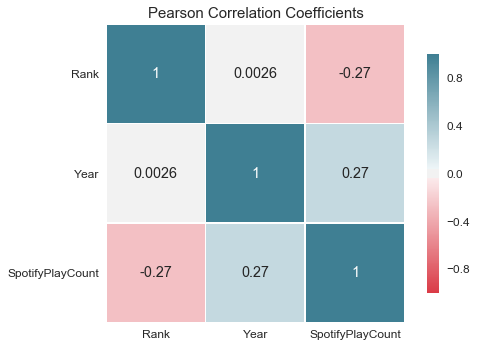

In [145]:
sns.set(style="white", font_scale=1.2)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Plot the Pearson correlation heatmap
ax = sns.heatmap(correlation, cmap=cmap, annot=True, center=0, 
                 square=True, linewidths=.7, cbar_kws={"shrink": .8})
plt.yticks(rotation=0) 
ax.set_title('Pearson Correlation Coefficients', fontsize=15)

## 1.2 Plots

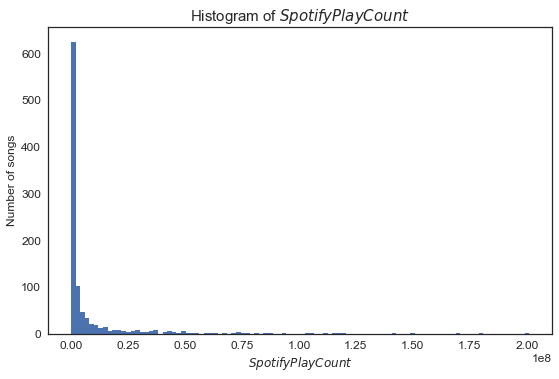

Mean:  7899715.501
Std:  19922589.896896116


In [135]:
# Plot . Histogram of SpotifyPlayCounts
sns.set(style="white")

num_bins = 100
ax = plt.subplot()
n, bins, patches = ax.hist(music_df.SpotifyPlayCount, num_bins)

ax.set_xlabel('$SpotifyPlayCount$', fontsize=12)
ax.set_ylabel('Number of songs', fontsize=12)
ax.set_title('Histogram of $SpotifyPlayCount$', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', music_df.SpotifyPlayCount.mean())
print('Std: ', music_df.SpotifyPlayCount.std())

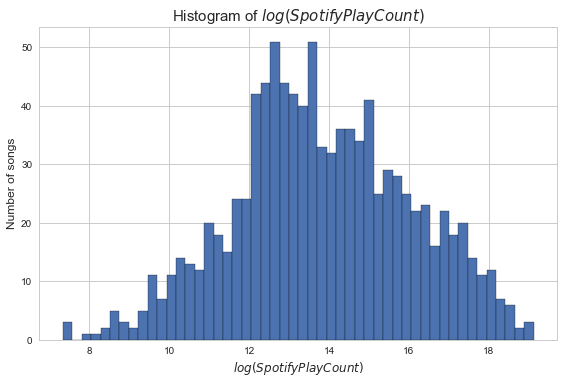

Mean:  13.84261285102407
Std:  2.213413059222591


In [142]:
# Plot . Histogram of log(SpotifyPlayCounts)
sns.set(style="whitegrid")

num_bins = 50
ax = plt.subplot()
n, bins, patches = ax.hist(np.log(music_df.SpotifyPlayCount), num_bins, edgecolor='black')

ax.set_xlabel('$log(SpotifyPlayCount)$', fontsize=12)
ax.set_ylabel('Number of songs', fontsize=12)
ax.set_title('Histogram of $log(SpotifyPlayCount)$', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', np.log(music_df.SpotifyPlayCount).mean())
print('Std: ', np.log(music_df.SpotifyPlayCount).std())

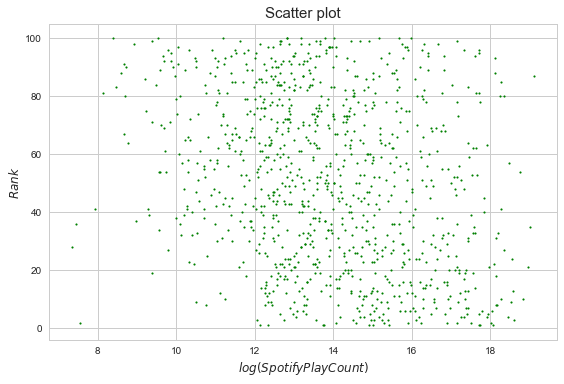

In [146]:
# Plot . Scatter plot of Rank and log(SpotifyPlayCounts)
sns.set(style="whitegrid")

ax = plt.subplot()
ax.scatter(np.log(music_df.SpotifyPlayCount), music_df.Rank, 
           s=3, color='green')

ax.set_xlabel('$log(SpotifyPlayCount)$', fontsize=12)
ax.set_ylabel('$Rank$', fontsize=12)
ax.set_title('Scatter plot', fontsize=15)

plt.tight_layout()
plt.show()

# 2 Data scraping

## Extract artist data

In [38]:
# Extract Artist column - File 'billboard_artist_name.csv'
artist_df = pd.DataFrame(music_df.Artist.unique())
artist_df.columns = ['Artist']

In [40]:
artist_df.to_csv('../music_data/billboard_artist_name.csv', sep=',', index=False)

## wikipedia package (python)

python code : wikipedia_scrape_wordcount.py

# 3. Model

## 3.1 Preprocessing

In [147]:
# Read artist dataset
artist_df = pd.read_csv('../music_data/billboard_artist_wordcount.csv', na_values=['NA'])

In [148]:
artist_df.describe(include='all')

,Artist,WikiWordCount
count,547,547.000000
unique,547,NaN
top,Connie Stevens,NaN
freq,1,NaN
mean,NaN,2166.974406
std,NaN,2617.383243
min,NaN,108.000000
25%,NaN,651.000000
50%,NaN,1278.000000
75%,NaN,2541.000000


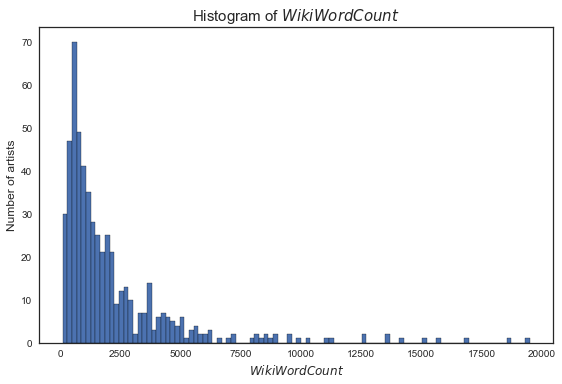

Mean:  2166.9744058500914
Std:  2617.383243489533


In [151]:
# Plot . Histogram of Wikipedia word count
sns.set(style="white")

num_bins = 100
ax = plt.subplot()
n, bins, patches = ax.hist(artist_df.WikiWordCount, num_bins, edgecolor='black')

ax.set_xlabel('$WikiWordCount$', fontsize=12)
ax.set_ylabel('Number of artists', fontsize=12)
ax.set_title('Histogram of $WikiWordCount$', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', artist_df.WikiWordCount.mean())
print('Std: ', artist_df.WikiWordCount.std())

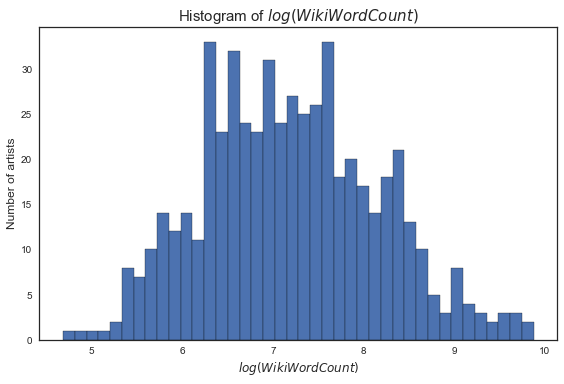

Mean:  7.199045109926113
Std:  0.9639198424125061


In [155]:
# Plot . Histogram of log(WikipediaWordCount)
sns.set(style="white")

num_bins = 40
ax = plt.subplot()
n, bins, patches = ax.hist(np.log(artist_df.WikiWordCount), num_bins, edgecolor='black')

ax.set_xlabel('$log(WikiWordCount)$', fontsize=12)
ax.set_ylabel('Number of artists', fontsize=12)
ax.set_title('Histogram of $log(WikiWordCount)$', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', np.log(artist_df.WikiWordCount).mean())
print('Std: ', np.log(artist_df.WikiWordCount).std())

In [158]:
music_dataset = pd.merge(music_df_logtarget, artist_df, on='Artist')
music_dataset.describe(include='all')

,Rank,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
count,1000.000000,1000,1000,1000.000000,1000.000000,1000.000000
unique,NaN,547,987,NaN,NaN,NaN
top,NaN,The Beatles,Red Roses for a Blue Lady,NaN,NaN,NaN
freq,NaN,23,2,NaN,NaN,NaN
mean,50.547000,NaN,NaN,1964.501000,13.842613,3361.737000
std,28.922799,NaN,NaN,2.875111,2.213413,3937.524284
min,1.000000,NaN,NaN,1960.000000,7.348588,108.000000
25%,25.750000,NaN,NaN,1962.000000,12.403722,951.000000
50%,50.500000,NaN,NaN,1964.500000,13.669471,1942.500000
75%,76.000000,NaN,NaN,1967.000000,15.417700,4194.000000


In [162]:
music_dataset_norm = music_dataset.copy()

In [163]:
music_dataset_norm.WikiWordCount = np.log(music_dataset_norm.WikiWordCount)

In [164]:
def z_score_norm(df, feature_list):
    """ Dot the z-score method on selected features in feature_list. 
        z = (x - mean)/std
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())

In [165]:
z_score_norm(music_dataset_norm, feature_list=['Rank','Year','WikiWordCount'])

In [167]:
music_dataset_norm.describe(include='all')

,Rank,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
count,1.000000e+03,1000,1000,1.000000e+03,1000.000000,1.000000e+03
unique,NaN,547,987,NaN,NaN,NaN
top,NaN,The Beatles,Red Roses for a Blue Lady,NaN,NaN,NaN
freq,NaN,23,2,NaN,NaN,NaN
mean,2.797762e-17,NaN,NaN,1.023182e-14,13.842613,8.594347e-15
std,1.000000e+00,NaN,NaN,1.000000e+00,2.213413,1.000000e+00
min,-1.713078e+00,NaN,NaN,-1.565505e+00,7.348588,-2.788130e+00
25%,-8.573513e-01,NaN,NaN,-8.698794e-01,12.403722,-6.998582e-01
50%,-1.625016e-03,NaN,NaN,-3.478126e-04,13.669471,-1.425531e-02
75%,8.800324e-01,NaN,NaN,8.691837e-01,15.417700,7.246168e-01


## 3.2  Baseline Model - Linear regression

In [187]:
feature_base = music_dataset_norm.loc[:,['Rank','Year']]
target = music_dataset_norm.loc[:,'SpotifyPlayCount']

In [188]:
linear_regr_base = linear_model.LinearRegression()

In [189]:
def performance_statistics(model_name, target, pred):
    '''Plot a table of performance statistics
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    mae   = mean_absolute_error(target, pred)
    medae = median_absolute_error(target, pred)
    r2    = r2_score(target, pred)
    
    columns = ['Model', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score']
    cell_text = [['%s' % model_name, '%1.3f' % mae, '%1.3f' % medae, '%1.3f' % r2]]
    
    nrow = 1
    ncol = len(columns)
    
    fig = plt.figure(figsize=(ncol*2, nrow*0.2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center')
    table.set_fontsize(14)
    table.scale(1.5, 1.5)

In [190]:
def error_distribution(model_name, target, pred):
    '''Plot a histogram of the error distribution
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    err = pred - target   # error is a Series
    min_err = err.min()
    max_err = err.max()
    ax = err.plot.hist(bins=20, figsize=(7,7), alpha=0.8)
    ax.set_xticks(np.arange(math.floor(min_err), math.ceil(max_err)))
    ax.set_title('%s - Error Distribution' % model_name, fontsize=18)
    ax.set_xlabel('Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.grid()

In [191]:
def prediction_error_map(model_name, target, pred):
    '''Plot the prediction error map (similar to confusion matrices in classification problems)
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    y_min = target.min()*0.98
    y_max = target.max()*1.01
    fig, ax = plt.subplots(figsize=(7,7))
    plt.scatter(target, pred, edgecolors=(0, 0, 0), s=20)
    ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)
    ax.set_xticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_yticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_title('%s - Prediction Error Map' % model_name, fontsize=18)
    #ax.set_xlabel('Real Spotify (log) Play Count', fontsize=14)
    ax.set_xlabel('Target', fontsize=14)
    ax.set_ylabel('Prediction', fontsize=14)
    ax.axis([y_min,y_max,y_min,y_max])
    ax.grid()

In [192]:
def evaluation(model, feature, target):
    """ Run the model on X and y using cross validation. Then output:
        1) performance statistics
        2) error distributions
        3) prediction error map
        
    Args:
        model   (object):    the machine learning object to fit the data
        feature (DataFrame): feature data
        target  (Series):    target  data
        
    This is version 0.11.10 (Nov. 10th)
    
    Todo:
        parameter "model" should be a list of models in the future
    """
    
    model_name = str(model)        # 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)'
    end = model_name.find('(')
    model_name = model_name[0:end] # 'LinearRegression'
    
    '''Do the prediction by cross validation'''
    pred = cross_val_predict(model, X=feature, y=target, cv=10)  # default is 10-fold
    
    print('This is the plots/reports of %s'  % model_name)
        
    error_distribution(model_name, target, pred)
    
    prediction_error_map(model_name, target, pred)
    
    performance_statistics(model_name, target, pred)

This is the plots/reports of LinearRegression


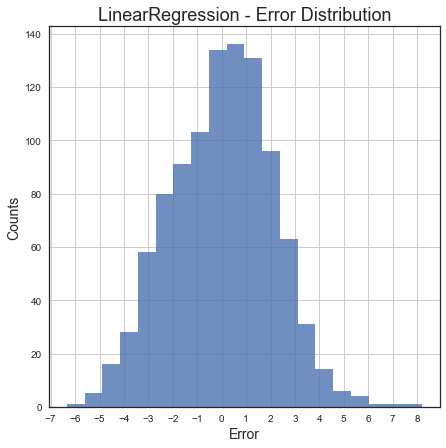

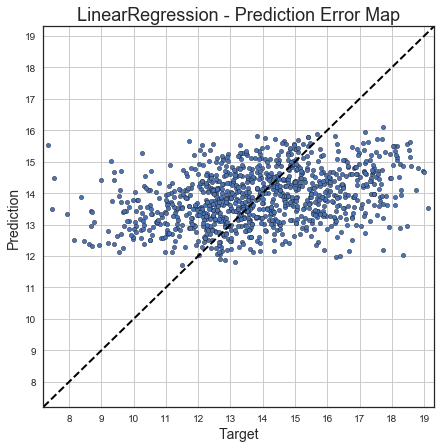

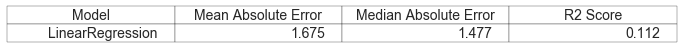

In [193]:
evaluation(linear_regr_base, feature_base, target)

## 3.3  Advanced Model - Linear regression

In [194]:
feature = music_dataset_norm.loc[:,['Rank','Year','WikiWordCount']]
target = music_dataset_norm.loc[:,'SpotifyPlayCount']

In [195]:
linear_regr = linear_model.LinearRegression()

This is the plots/reports of LinearRegression


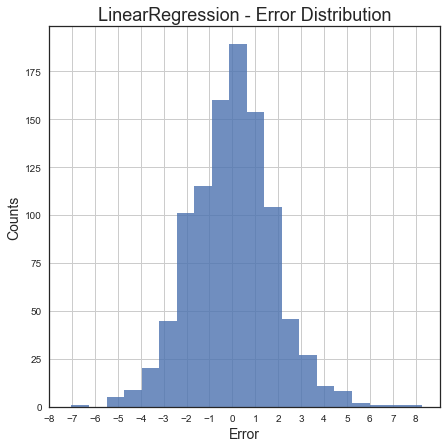

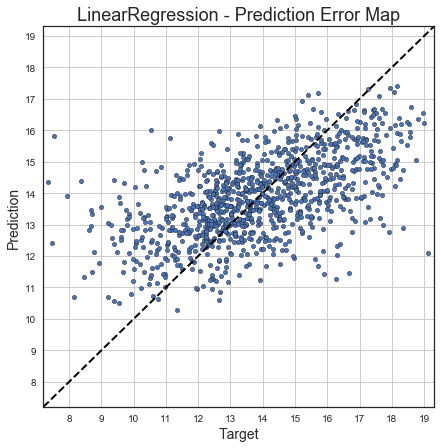

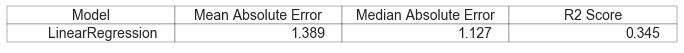

In [196]:
evaluation(linear_regr, feature, target)

## 3.4 Advanced Model - Support Vector Regression

In [202]:
svr_poly = SVR(kernel='linear', C=1e3)

This is the plots/reports of SVR


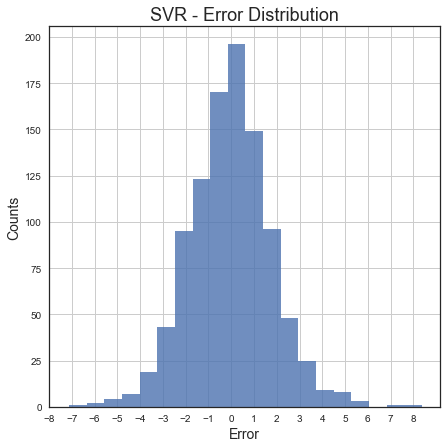

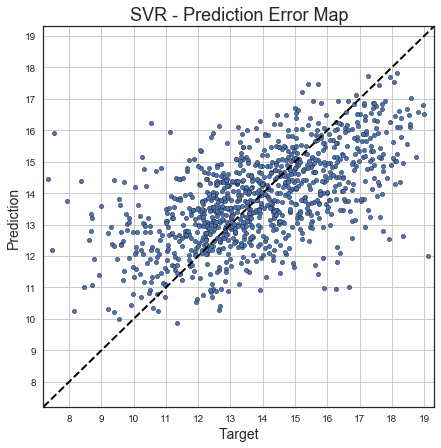

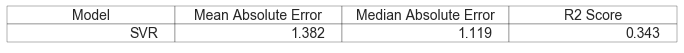

In [203]:
evaluation(svr_poly, feature, target)

In [40]:
#artist_df = pd.read_csv('../music_data/billboard_artist_name.csv', na_values=['NA'])
music_corgis_df = pd.read_csv('../../../Project/music_corgis.csv', na_values=['NA'])

result = pd.merge(music_df, music_corgis_df, how='left', 
                  left_on=['Artist','Title'], right_on=['artist.name','title'])

In [41]:
result

,Rank,Artist,Title,Year,SpotifyPlayCount,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,1,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jim Reeves,He'll Have To Go,1960,4377343,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,The Everly Brothers,Cathy's Clown,1960,4180758,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Johnny Preston,Running Bear,1960,1444980,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Mark Dinning,Teen Angel,1960,436274,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,Brenda Lee,I'm Sorry,1960,3366175,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,Elvis Presley,It's Now Or Never,1960,11766868,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,Jimmy Jones,Handy Man,1960,564091,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,Elvis Presley,Stuck On You,1960,6695034,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,Chubby Checker,The Twist,1960,15600003,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
music_corgis_join = result
music_corgis_join.to_csv('../music_data/music_corgis_join_artist-title.csv', sep=',', index=False)

In [43]:
result = pd.merge(music_df, music_corgis_df, how='left', 
                  left_on='Artist', right_on='artist.name')

In [44]:
result

,Rank,Artist,Title,Year,SpotifyPlayCount,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,1,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,0.388113,ARFTMGO1187B9A777A,Percy Faith,NaN,0.0,...,156.386,0.357,0.18997,86.141,instrumental pop,0.939272,4.0,0.770,Yesterdays,0.0
1,1,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,0.388113,ARFTMGO1187B9A777A,Percy Faith,NaN,0.0,...,152.561,0.213,0.45974,89.924,instrumental pop,0.939272,1.0,0.455,I Loves You Porgy,0.0
2,1,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,0.388113,ARFTMGO1187B9A777A,Percy Faith,NaN,0.0,...,144.730,0.236,0.14405,127.853,instrumental pop,0.939272,1.0,0.000,Do Re Mi,0.0
3,1,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,0.388113,ARFTMGO1187B9A777A,Percy Faith,NaN,0.0,...,160.049,0.336,0.23409,158.009,instrumental pop,0.939272,3.0,1.000,Under The Bridges Of Paris,0.0
4,1,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,0.388113,ARFTMGO1187B9A777A,Percy Faith,NaN,0.0,...,141.125,0.266,0.65167,107.405,instrumental pop,0.939272,3.0,0.653,The Song Is You,0.0
5,2,Jim Reeves,He'll Have To Go,1960,4377343,0.462190,ARZVTZN1187FB579D4,Jim Reeves,classic pop and rock,1.0,...,141.038,0.577,0.17020,91.318,country gospel,1.000000,4.0,0.785,I Guess I'm Crazy,1990.0
6,2,Jim Reeves,He'll Have To Go,1960,4377343,0.462190,ARZVTZN1187FB579D4,Jim Reeves,classic pop and rock,1.0,...,116.878,0.563,0.20702,151.730,country gospel,1.000000,3.0,0.878,I'd Like To Be,1994.0
7,2,Jim Reeves,He'll Have To Go,1960,4377343,0.462190,ARZVTZN1187FB579D4,Jim Reeves,classic pop and rock,1.0,...,155.318,0.765,0.16224,126.689,country gospel,1.000000,1.0,0.000,Mexican Joe,1990.0
8,2,Jim Reeves,He'll Have To Go,1960,4377343,0.462190,ARZVTZN1187FB579D4,Jim Reeves,classic pop and rock,1.0,...,167.706,0.516,0.21581,158.763,country gospel,1.000000,3.0,0.634,Rosa Rio,2000.0
9,2,Jim Reeves,He'll Have To Go,1960,4377343,0.462190,ARZVTZN1187FB579D4,Jim Reeves,classic pop and rock,1.0,...,150.117,0.725,0.33990,87.038,country gospel,1.000000,4.0,0.991,May The Good Lord Bless And Keep You,2000.0


In [45]:
music_corgis_join = result
music_corgis_join.to_csv('../music_data/music_corgis_join_artist.csv', sep=',', index=False)

# Wikipedia Scraping (BeautifulSoup)

In [1]:
import bs4
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

my_url = 'https://en.wikipedia.org/wiki/Barry_Sadler'
# Open up connection, grab the page
uClient = uReq(my_url)
page_html = uClient.read()
uClient.close()

# html parsing
page_soup = soup(page_html, "html.parser")
page_soup.h1

<h1 class="firstHeading" id="firstHeading" lang="en">Barry Sadler</h1>

In [23]:
# Grab each product
#containers = page_soup.findAll("div", {"class":"item-container"})
#containers = page_soup.findAll("div", {"class":"mw-body-content"})
containers = page_soup.findAll("div", {"class":"mw-content-ltr"})
len(containers)

1

In [38]:
containers[0].div.p

<p><b>Barry Allen Sadler</b> (November 1, 1940 – November 5, 1989) was an American <a class="mw-redirect" href="/wiki/United_States_Military" title="United States Military">military veteran</a>, singer/songwriter and author. Sadler served as a <a class="mw-redirect" href="/wiki/United_States_Army_Special_Forces" title="United States Army Special Forces">Green Beret</a> medic, achieving the rank of <a class="mw-redirect" href="/wiki/Staff_Sergeant#United_States" title="Staff Sergeant">Staff Sergeant</a>. He served in the Vietnam War from late December 1964 to late May 1965. Most of his work has a military theme, and he is best known for his "<a href="/wiki/Ballad_of_the_Green_Berets" title="Ballad of the Green Berets">Ballad of the Green Berets</a>," the No. 1 pop song of 1966.</p>

In [39]:
info_table = page_soup.findAll("table", {"class":"infobox vcard"})
info_table

[<table class="infobox vcard" style="width:22em;width:315px;border-spacing:2px;">
 <tr>
 <th colspan="2" style="text-align:center;font-size:125%;font-weight:bold;background-color:#B0C4DE;"><span class="fn">Barry Sadler</span></th>
 </tr>
 <tr>
 <td colspan="2" style="text-align:center;border-bottom: 1px solid #aaa;; line-height: 1.5em"><a class="image" href="/wiki/File:Barry_Sadler.png"><img alt="Barry Sadler.png" data-file-height="494" data-file-width="494" height="220" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/220px-Barry_Sadler.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/330px-Barry_Sadler.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/440px-Barry_Sadler.png 2x" width="220"/></a>
 <div style="font-size: 100%">Barry Sadler in 1966</div>
 </td>
 </tr>
 <tr>
 <th scope="row" style="padding-right: 1em">Born</th>
 <td><span style="display:none">(<span class="bday">1940-11-01</span>)</spa

In [42]:
info_table[0]

<table class="infobox vcard" style="width:22em;width:315px;border-spacing:2px;">
<tr>
<th colspan="2" style="text-align:center;font-size:125%;font-weight:bold;background-color:#B0C4DE;"><span class="fn">Barry Sadler</span></th>
</tr>
<tr>
<td colspan="2" style="text-align:center;border-bottom: 1px solid #aaa;; line-height: 1.5em"><a class="image" href="/wiki/File:Barry_Sadler.png"><img alt="Barry Sadler.png" data-file-height="494" data-file-width="494" height="220" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/220px-Barry_Sadler.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/330px-Barry_Sadler.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/440px-Barry_Sadler.png 2x" width="220"/></a>
<div style="font-size: 100%">Barry Sadler in 1966</div>
</td>
</tr>
<tr>
<th scope="row" style="padding-right: 1em">Born</th>
<td><span style="display:none">(<span class="bday">1940-11-01</span>)</span>November 1

In [52]:
info_table[0].text

'\n\nBarry Sadler\n\n\n\nBarry Sadler in 1966\n\n\n\nBorn\n(1940-11-01)November 1, 1940\nCarlsbad, New Mexico, U.S.\n\n\nDied\nNovember 5, 1989(1989-11-05) (aged\xa049)\nMurfreesboro, Tennessee, U.S.\n\n\nAllegiance\n\xa0United States of America\n\n\nService/branch\n\xa0United States Air Force (1958-1962)\n\xa0United States Army (1962-1967)\n\n\nYears\xa0of service\n1958-1967\n\n\nRank\n Staff Sergeant\n\n\nUnit\n U.S. Army Special Forces - 7th Special Forces Group (Airborne)\n\n\nBattles/wars\nVietnam War\n\n'

In [56]:
info_table[0].th.span.text

'Barry Sadler'

In [66]:
info_table[0]

<table class="infobox vcard" style="width:22em;width:315px;border-spacing:2px;">
<tr>
<th colspan="2" style="text-align:center;font-size:125%;font-weight:bold;background-color:#B0C4DE;"><span class="fn">Barry Sadler</span></th>
</tr>
<tr>
<td colspan="2" style="text-align:center;border-bottom: 1px solid #aaa;; line-height: 1.5em"><a class="image" href="/wiki/File:Barry_Sadler.png"><img alt="Barry Sadler.png" data-file-height="494" data-file-width="494" height="220" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/220px-Barry_Sadler.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/330px-Barry_Sadler.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Barry_Sadler.png/440px-Barry_Sadler.png 2x" width="220"/></a>
<div style="font-size: 100%">Barry Sadler in 1966</div>
</td>
</tr>
<tr>
<th scope="row" style="padding-right: 1em">Born</th>
<td><span style="display:none">(<span class="bday">1940-11-01</span>)</span>November 1

In [ ]:
product_name.replace(",", "|")